In [447]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import seaborn as sns
from fbprophet import Prophet

In [449]:
df = pd.read_excel('../1_data/Deposits Received.xlsx', usecols=['CWID number','Round', 'Payment - Most Recent Date'])
df.head()

,CWID number,Round,Payment - Most Recent Date
0,10306224.0,2018 Fall First-Year Application,NaT
1,10323533.0,2019 Fall Transfer Application,NaT
2,10310570.0,2018 Fall First-Year Application,NaT
3,10302035.0,2017 Fall First-Year Application,NaT
4,10308533.0,2018 Fall First-Year Application,NaT


In [450]:
df = df[pd.notna(df['Payment - Most Recent Date'])]
df['CWID number'].count()

2330

In [451]:
df.reset_index(inplace=True, drop=True)
df.head()

,CWID number,Round,Payment - Most Recent Date
0,10302395.0,2017 Fall First-Year Application,2017-03-27 10:16:38
1,10299774.0,2017 Fall First-Year Application,2017-04-30 10:26:55
2,10314090.0,2019 Fall First-Year Application,2019-02-08 19:51:40
3,10328204.0,2020 Fall First-Year Application,2020-02-09 22:25:33
4,10316768.0,2019 Fall First-Year Application,2018-12-20 21:49:30


In [452]:
df['Round'].value_counts()

2019 Fall First-Year Application    756
2018 Fall First-Year Application    685
2017 Fall First-Year Application    653
2020 Fall First-Year Application     98
2018 Fall Transfer Application       45
2017 Fall Transfer Application       42
2019 Fall Transfer Application       40
2019 Fall Readmit Application         4
2020 Fall Transfer Application        4
2018 Fall Readmit Application         3
Name: Round, dtype: int64

In [453]:
# new data frame with split value columns 
new = df["Round"].str.split(" Fall", n = 1, expand = True) 
  
# making separate first name column from new data frame 
df["Year"]= new[0] 

df.head()

,CWID number,Round,Payment - Most Recent Date,Year
0,10302395.0,2017 Fall First-Year Application,2017-03-27 10:16:38,2017
1,10299774.0,2017 Fall First-Year Application,2017-04-30 10:26:55,2017
2,10314090.0,2019 Fall First-Year Application,2019-02-08 19:51:40,2019
3,10328204.0,2020 Fall First-Year Application,2020-02-09 22:25:33,2020
4,10316768.0,2019 Fall First-Year Application,2018-12-20 21:49:30,2019


In [454]:
df['Year'].value_counts(dropna=False)

2019    800
2018    733
2017    695
2020    102
Name: Year, dtype: int64

In [455]:
df.drop('Round', axis=1, inplace=True)

In [456]:
df['ds'] = df['Payment - Most Recent Date'].dt.date 
df.drop('Payment - Most Recent Date', axis=1, inplace=True)
df.head()

,CWID number,Year,ds
0,10302395.0,2017,2017-03-27
1,10299774.0,2017,2017-04-30
2,10314090.0,2019,2019-02-08
3,10328204.0,2020,2020-02-09
4,10316768.0,2019,2018-12-20


In [457]:
df['CWID number'].nunique()-df['CWID number'].count()

-7

In [458]:
df[df.duplicated('CWID number')]

,CWID number,Year,ds
286,10310132.0,2019,2019-04-26
612,10308348.0,2019,2019-03-19
785,10308140.0,2019,2019-08-08
1526,10308125.0,2019,2019-04-25
1608,10309403.0,2019,2019-08-14
1958,10312236.0,2018,2018-07-20
1963,10303726.0,2017,2017-04-25


In [459]:
df[df['CWID number']==10310132.0]

,CWID number,Year,ds
285,10310132.0,2018,2018-04-21
286,10310132.0,2019,2019-04-26


Keep the dups as separate applications

In [460]:
df['y']=1
df.head()

,CWID number,Year,ds,y
0,10302395.0,2017,2017-03-27,1
1,10299774.0,2017,2017-04-30,1
2,10314090.0,2019,2019-02-08,1
3,10328204.0,2020,2020-02-09,1
4,10316768.0,2019,2018-12-20,1


In [461]:
df.to_excel('../3_res/dates.xlsx', index=False)

In [462]:
df.dtypes

CWID number    float64
Year            object
ds              object
y                int64
dtype: object

In [463]:
df['ds']=pd.to_datetime(df['ds'])
df.dtypes

CWID number           float64
Year                   object
ds             datetime64[ns]
y                       int64
dtype: object

In [464]:
ds = df.groupby('ds').sum()

In [465]:
ds.drop('CWID number', axis = 1, inplace = True)
ds.head()

,y
ds,
2017-01-26,1
2017-01-28,1
2017-01-29,1
2017-01-30,2
2017-01-31,1


In [466]:
ds.reset_index(inplace=True)
ds.head()

,ds,y
0,2017-01-26,1
1,2017-01-28,1
2,2017-01-29,1
3,2017-01-30,2
4,2017-01-31,1


In [467]:
ds.dtypes

ds    datetime64[ns]
y              int64
dtype: object

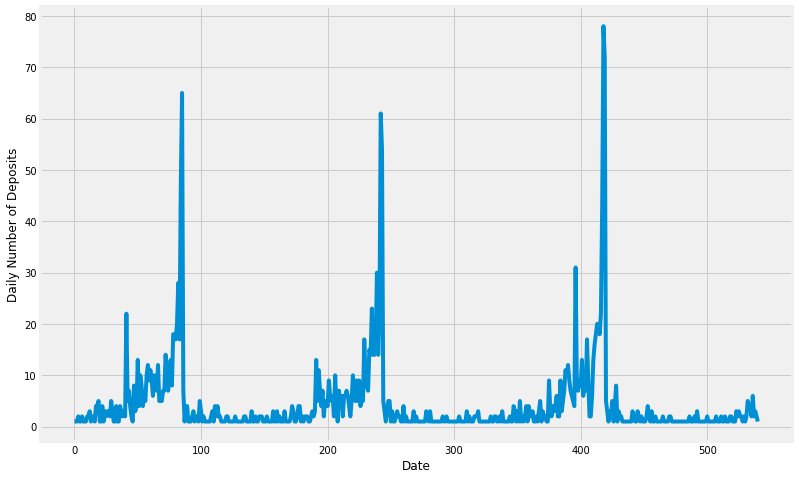

In [468]:
ax = ds['y'].plot(figsize=(12, 8))
ax.set_ylabel('Daily Number of Deposits')
ax.set_xlabel('Date')

plt.show()

In [469]:
ds['y'].count()

541

In [470]:
ds.tail()

,ds,y
536,2020-02-28,6
537,2020-02-29,2
538,2020-03-01,3
539,2020-03-02,2
540,2020-03-03,1


# Forecasting with Prophet

In [471]:
# set the uncertainty interval to 95% (the Prophet default is 80%)
my_model = Prophet(changepoint_range=0.95, daily_seasonality=True)
my_model.fit(ds)
future_dates = my_model.make_future_dataframe(periods=180)
future_dates.tail()

,ds
716,2020-08-26
717,2020-08-27
718,2020-08-28
719,2020-08-29
720,2020-08-30


In [472]:
forecast = my_model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
716,2020-08-26,-8.858868,-17.015818,-0.707274
717,2020-08-27,-11.338628,-19.752549,-3.648951
718,2020-08-28,-11.709281,-19.537395,-3.695593
719,2020-08-29,-13.154306,-20.716988,-5.494317
720,2020-08-30,-13.336776,-20.629153,-5.897211


In [473]:
forecast['yhat'][forecast['ds'] > '2019-10-01'].sum()

780.4736132787478

In [474]:
forecast['yhat'][(forecast['ds'] > '2019-10-01') & (forecast['ds'] < '2020-07-31')].sum()

843.5083701292418

# last two years

In [475]:
ds2 = ds[ds['ds']> '2017-10-01']
ds2['y'].count()

409

In [476]:
ds2['y'][ds['ds']> '2019-10-01'].count()

63

In [477]:
63/409

0.15403422982885084

In [478]:
my_model2 = Prophet(changepoint_range=0.85, daily_seasonality=True)
my_model2.fit(ds2)
future_dates2 = my_model2.make_future_dataframe(periods=180)
future_dates2.tail()

,ds
584,2020-08-26
585,2020-08-27
586,2020-08-28
587,2020-08-29
588,2020-08-30


In [479]:
forecast2 = my_model2.predict(future_dates2)
forecast2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
584,2020-08-26,-7.832206,-15.423179,-0.946005
585,2020-08-27,-10.516336,-18.773397,-3.164277
586,2020-08-28,-10.833471,-18.535594,-2.749516
587,2020-08-29,-12.402788,-19.607632,-4.519686
588,2020-08-30,-12.694051,-20.293413,-4.708409


In [480]:
forecast2['yhat'][forecast2['ds'] > '2019-10-01'].sum()

818.7914949029874

In [481]:
forecast2['yhat'][(forecast2['ds'] > '2019-10-01') & (forecast2['ds'] < '2020-07-31')].sum()

872.4674607078441

# Evaluate Both Models

In [482]:
eval1 = forecast[['ds', 'yhat']]
eval1 = eval1[(eval1['ds'] > '2019-10-01') & (eval1['ds'] < '2020-03-04')]
eval1['ds'].describe()

count                      63
unique                     63
top       2019-11-22 00:00:00
freq                        1
first     2019-10-18 00:00:00
last      2020-03-03 00:00:00
Name: ds, dtype: object

In [483]:
eval2 = forecast2[['ds', 'yhat']]
eval2 = eval2[(eval2['ds'] > '2019-10-01') & (eval2['ds'] < '2020-03-04')]
eval2['ds'].describe()

count                      63
unique                     63
top       2019-11-22 00:00:00
freq                        1
first     2019-10-18 00:00:00
last      2020-03-03 00:00:00
Name: ds, dtype: object

In [484]:
ds['ds'].describe()

count                     541
unique                    541
top       2019-02-21 00:00:00
freq                        1
first     2017-01-26 00:00:00
last      2020-03-03 00:00:00
Name: ds, dtype: object

In [485]:
ds_eval = ds[(ds['ds'] > '2019-10-01') & (ds['ds'] < '2020-03-04')]
ds_eval['ds'].describe()

count                      63
unique                     63
top       2019-11-22 00:00:00
freq                        1
first     2019-10-18 00:00:00
last      2020-03-03 00:00:00
Name: ds, dtype: object

In [486]:
eval2.head()

,ds,yhat
346,2019-10-18,1.209196
347,2019-10-21,1.672387
348,2019-10-24,-1.002645
349,2019-11-02,0.656925
350,2019-11-04,3.481963


In [487]:
evaluate = ds_eval.merge(eval1, on='ds', how='left')
evaluate = evaluate.merge(eval2, on='ds', how='left')
evaluate.head()

,ds,y,yhat_x,yhat_y
0,2019-10-18,1,1.166972,1.209196
1,2019-10-21,1,1.836688,1.672387
2,2019-10-24,1,-1.407320,-1.002645
3,2019-11-02,1,0.764165,0.656925
4,2019-11-04,1,3.887982,3.481963


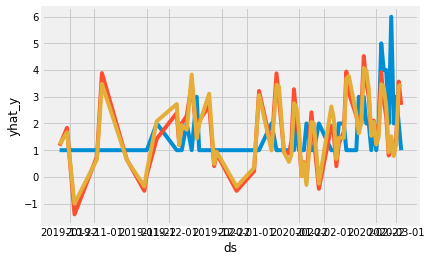

In [488]:
sns.lineplot(x='ds', y='y', data=evaluate)
sns.lineplot(x='ds', y='yhat_x', data=evaluate)
sns.lineplot(x='ds', y='yhat_y', data=evaluate)

# Convert to Weekly Data

In [489]:
evaluate['x']='x'
evaluate.head()

,ds,y,yhat_x,yhat_y,x
0,2019-10-18,1,1.166972,1.209196,x
1,2019-10-21,1,1.836688,1.672387,x
2,2019-10-24,1,-1.407320,-1.002645,x
3,2019-11-02,1,0.764165,0.656925,x
4,2019-11-04,1,3.887982,3.481963,x


In [490]:
weekly_data = evaluate.groupby("x").resample('W-Wed', label='right', closed = 'right', on='ds').sum().reset_index().sort_values(by='ds')

In [491]:
weekly_data.head()

,x,ds,y,yhat_x,yhat_y
0,x,2019-10-23,2,3.003659,2.881583
1,x,2019-10-30,1,-1.407320,-1.002645
2,x,2019-11-06,2,4.652148,4.138888
3,x,2019-11-13,0,0.000000,0.000000
4,x,2019-11-20,1,0.645402,0.631353


In [492]:
weekly_data.reset_index(inplace=True)
weekly_data['index']=weekly_data['index']+1
weekly_data.head()

,index,x,ds,y,yhat_x,yhat_y
0,1,x,2019-10-23,2,3.003659,2.881583
1,2,x,2019-10-30,1,-1.407320,-1.002645
2,3,x,2019-11-06,2,4.652148,4.138888
3,4,x,2019-11-13,0,0.000000,0.000000
4,5,x,2019-11-20,1,0.645402,0.631353


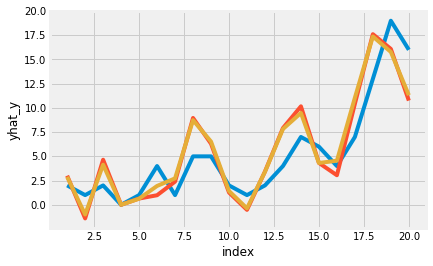

In [493]:
sns.lineplot(x='index', y='y', data=weekly_data)
sns.lineplot(x='index', y='yhat_x', data=weekly_data)
sns.lineplot(x='index', y='yhat_y', data=weekly_data)

# Try Weekly Predictions

In [494]:
ds.head()

,ds,y
0,2017-01-26,1
1,2017-01-28,1
2,2017-01-29,1
3,2017-01-30,2
4,2017-01-31,1


In [495]:
ds['x']='x'
ds2['x']='x'

In [496]:
ds2.head()

,ds,y,x
132,2017-11-17,1,x
133,2017-11-18,1,x
134,2017-11-20,2,x
135,2017-12-01,2,x
136,2017-12-03,1,x


In [497]:
ds_week = ds.groupby("x").resample('W-Wed', label='right', closed = 'right', on='ds').sum().reset_index().sort_values(by='ds')
ds_week2 = ds2.groupby("x").resample('W-Wed', label='right', closed = 'right', on='ds').sum().reset_index().sort_values(by='ds')
 

In [498]:
ds_week.head()

,x,ds,y
0,x,2017-02-01,6
1,x,2017-02-08,5
2,x,2017-02-15,8
3,x,2017-02-22,19
4,x,2017-03-01,12


In [508]:
ds_week['ds'].count()

162

In [499]:
ds_week.drop('x', axis=1, inplace=True)
ds_week2.drop('x', axis=1, inplace=True)
ds_week2.head()

,ds,y
0,2017-11-22,4
1,2017-11-29,0
2,2017-12-06,3
3,2017-12-13,3
4,2017-12-20,4


In [534]:
my_model3 = Prophet(changepoint_range=0.95, weekly_seasonality=True, daily_seasonality=True)
my_model3.fit(ds_week)
future_dates3 = my_model3.make_future_dataframe(periods=26, freq='w')
forecast3 = my_model3.predict(future_dates3)
print(forecast3['yhat'][forecast3['ds'] > '2019-10-01'].sum())
print(forecast3['yhat'][(forecast3['ds'] > '2019-10-01') & (forecast3['ds'] < '2020-07-31')].sum())

761.1560681918943
758.0127332824014


In [535]:
my_model4 = Prophet(changepoint_range=0.85, weekly_seasonality=True, daily_seasonality=True)
my_model4.fit(ds_week2)
future_dates4 = my_model4.make_future_dataframe(periods=26, freq='w')
forecast4 = my_model4.predict(future_dates4)
print(forecast4['yhat'][forecast4['ds'] > '2019-10-01'].sum())
print(forecast4['yhat'][(forecast4['ds'] > '2019-10-01') & (forecast4['ds'] < '2020-07-31')].sum())

727.9581390454156
731.7023991205787


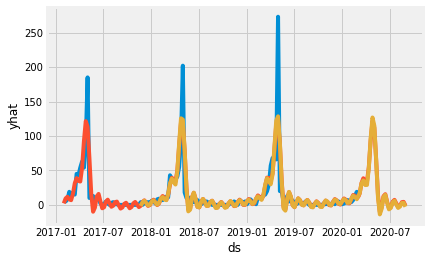

In [536]:
sns.lineplot(x='ds', y='y', data=ds_week)
sns.lineplot(x='ds', y='yhat', data=forecast3)
sns.lineplot(x='ds', y='yhat', data=forecast4)

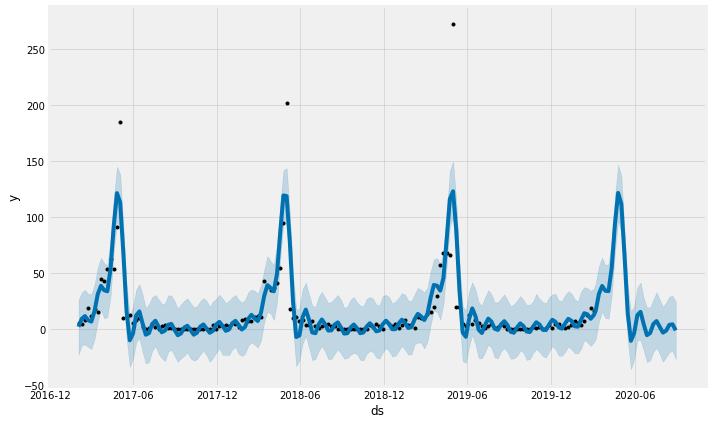

In [540]:
my_model3.plot(forecast3);

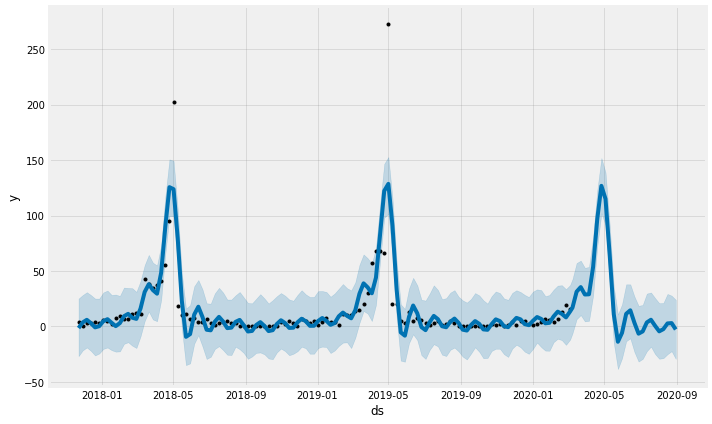

In [541]:
my_model4.plot(forecast4);